In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, reduce, repeat

In [2]:
!wget https://raw.githubusercontent.com/MASTREX/List-of-Indian-Names/master/2.%20First.txt -O names-indian.txt

--2024-05-30 09:41:48--  https://raw.githubusercontent.com/MASTREX/List-of-Indian-Names/master/2.%20First.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8752 (8.5K) [text/plain]
Saving to: ‘names-indian.txt’

names-indian.txt    100%[===================>]   8.55K  --.-KB/s    in 0s      

2024-05-30 09:41:49 (33.8 MB/s) - ‘names-indian.txt’ saved [8752/8752]



In [2]:
import pandas as pd
pd.read_csv('names-indian.txt', header=None)

,0
0,Abhishek
1,Aman
2,Harsh
3,Ayush
4,Aditi
...,...
1160,Prasoon
1161,Madhusudan
1162,Prastuti
1163,Rampratap


In [3]:
# convert all names to lowercase
names = pd.read_csv('names-indian.txt', header=None)[0].str.lower().values

In [4]:
names

array(['abhishek', 'aman', 'harsh', ..., 'prastuti', 'rampratap',
       'madhukar'], dtype=object)

Text(0, 0.5, 'Density')

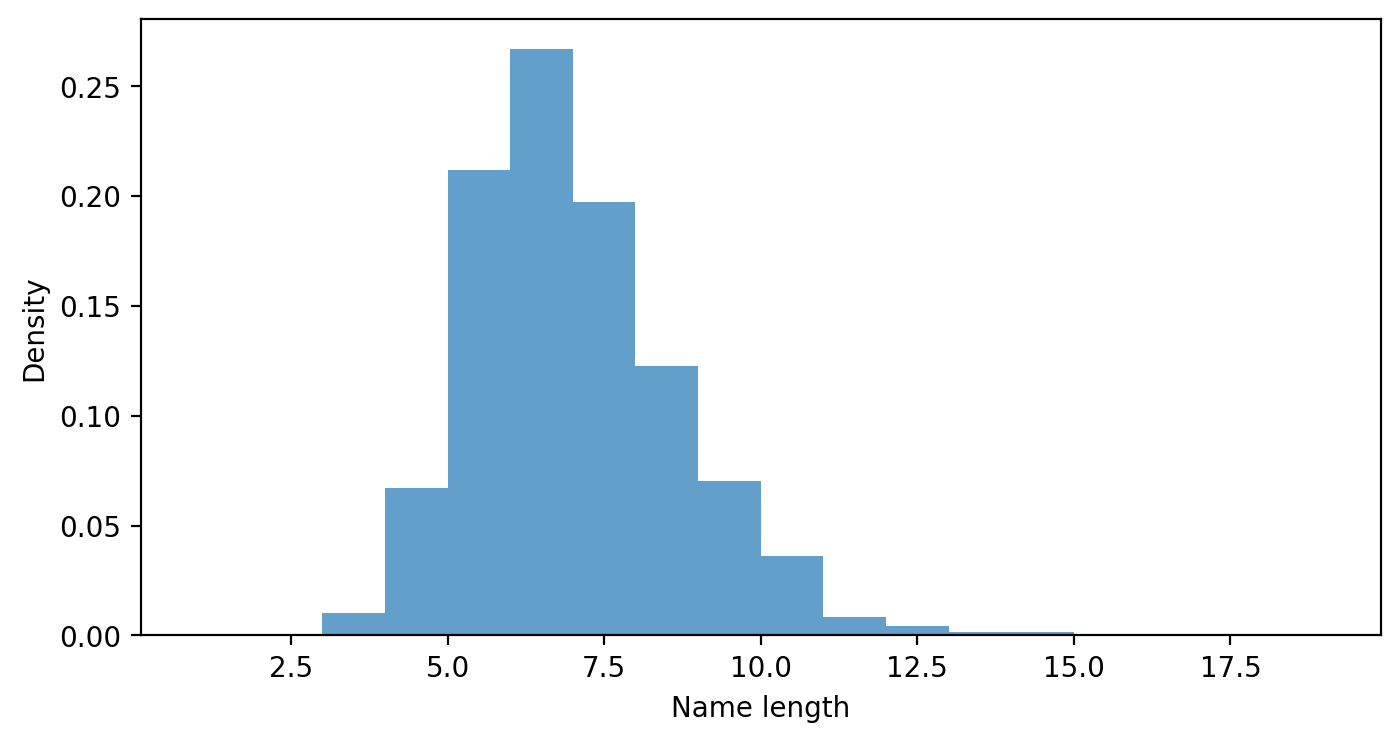

In [5]:
# KDE plot of name lengths
plt.figure(figsize=(8, 4))
plt.hist([len(name) for name in names], bins=range(1, 20), density=True, alpha=0.7)
plt.xlabel('Name length')
plt.ylabel('Density')

In [6]:
# Attach START and END tokens to each name. Need to add these two to the vocabulary.
start_symbol = '^'
end_symbol = '$'

names = [start_symbol + name + end_symbol for name in names]
names[:5]


['^abhishek$', '^aman$', '^harsh$', '^ayush$', '^aditi$']

In [7]:
# Find unique characters in the dataset
vocab = set(''.join(names))
vocab = sorted(vocab)
print(vocab, len(vocab))

['$', '^', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'] 28


In [8]:
# Create a d dimensional lookup table for each character in the vocabulary
class CharTable:
    def __init__(self, vocab):
        self.vocab = vocab
        self.char2index = {c: i for i, c in enumerate(vocab)}
        self.index2char = {i: c for i, c in enumerate(vocab)}
        self.vocab_size = len(vocab)
    
    def encode(self, name):
        return torch.tensor([self.char2index[c] for c in name])
    
    def decode(self, tensor):
        if type(tensor) == torch.Tensor:
            tensor = tensor.cpu().numpy()
        return ''.join([self.index2char[i] for i in tensor])

In [9]:
ct = CharTable(vocab)

Let us process the first name in the dataset 

In [55]:
# create embedding layer
class CharEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super(CharEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        
    def forward(self, x):
        return self.embedding(x)

embedding_dim = 8
char_embedding = CharEmbedding(ct.vocab_size, embedding_dim )

In [56]:
name = names[0]

encoding = ct.encode(name)
print(name, encoding, ct.decode(encoding), char_embedding(encoding))

^abhishek$ tensor([ 1,  2,  3,  9, 10, 20,  9,  6, 12,  0]) ^abhishek$ tensor([[-1.3499, -0.8886, -0.6833, -2.4340, -0.3476, -0.2824,  0.3694, -1.2859],
        [ 0.6961, -0.3760, -1.1183,  2.2782, -1.3446,  0.2088,  0.4919, -0.1777],
        [-0.3584,  0.3688,  0.3429,  0.2168,  2.0347, -1.5288, -0.4697, -0.3612],
        [-1.5195,  2.0605,  0.2935,  0.0287,  0.2705, -1.4502, -0.6650,  0.3143],
        [-0.6630,  0.0302,  0.4576,  0.3651, -1.6005, -0.5861, -1.9137, -0.4006],
        [ 0.0552,  0.1175,  1.7384,  0.0691,  1.1881,  0.1506, -0.3215,  2.6402],
        [-1.5195,  2.0605,  0.2935,  0.0287,  0.2705, -1.4502, -0.6650,  0.3143],
        [-0.1919,  1.4137,  0.0158, -0.0030, -0.6109,  0.4661, -0.1131,  0.2733],
        [ 0.8686,  0.3222, -0.2661,  2.1850, -1.3195, -0.6661,  0.8780,  0.2122],
        [ 0.6729,  0.4587, -0.3165,  1.4831,  0.1030, -1.4689,  0.4894,  1.2956]],
       grad_fn=<EmbeddingBackward0>)


In [57]:
print(char_embedding(encoding).shape)

torch.Size([10, 8])


In [58]:
xs=[]
for i in range(len(name)):
    xs.append(char_embedding(ct.encode(name[i])))

In [59]:
length_name = len(name)

In [60]:
d = 4
val_linear = nn.Linear(embedding_dim, embedding_dim)

query_linear = nn.Linear(embedding_dim, d)
key_linear = nn.Linear(embedding_dim, d)


In [61]:
vs = []
for i in range(length_name):
    vs.append(val_linear(xs[i]))


In [62]:
vs

[tensor([[-0.5005,  1.1128,  0.8048,  0.3994,  0.8465, -1.2007, -0.3687,  0.2159]],
        grad_fn=<AddmmBackward0>),
 tensor([[-0.2514, -0.1905, -0.5204,  0.0249, -0.1457,  0.2114,  0.3625,  0.5944]],
        grad_fn=<AddmmBackward0>),
 tensor([[ 0.2653, -0.4796, -0.9962,  0.3799,  0.1251,  0.3504,  0.2554, -0.4853]],
        grad_fn=<AddmmBackward0>),
 tensor([[ 0.1296, -0.0862, -0.9042, -0.4130, -0.2025, -0.7218,  0.4927, -0.0048]],
        grad_fn=<AddmmBackward0>),
 tensor([[-1.1825,  0.4473, -0.7623, -0.5004, -0.6020, -0.9123, -0.4412,  0.3128]],
        grad_fn=<AddmmBackward0>),
 tensor([[ 0.5342, -0.9138, -0.6400, -0.0377, -0.0354,  0.3041, -1.2578,  0.3234]],
        grad_fn=<AddmmBackward0>),
 tensor([[ 0.1296, -0.0862, -0.9042, -0.4130, -0.2025, -0.7218,  0.4927, -0.0048]],
        grad_fn=<AddmmBackward0>),
 tensor([[-0.0751, -0.1357, -0.5498, -0.0227,  0.0025, -0.0453, -0.2706, -0.0690]],
        grad_fn=<AddmmBackward0>),
 tensor([[ 0.1425, -0.2478, -0.5700, -0.0055, -0

In [31]:
qs = []
for i in range(length_name):
    qs.append(query_linear(xs[i]))

ks = []
for i in range(length_name):
    ks.append(key_linear(xs[i]))
    


In [32]:
qs

[tensor([[-0.5431, -0.8826, -2.0655,  0.3620]], grad_fn=<AddmmBackward0>),
 tensor([[ 0.2952, -0.6107, -0.4607,  1.6180]], grad_fn=<AddmmBackward0>),
 tensor([[0.3232, 0.1415, 0.1938, 0.1639]], grad_fn=<AddmmBackward0>),
 tensor([[-0.0149, -0.6881, -0.9877,  0.9795]], grad_fn=<AddmmBackward0>),
 tensor([[ 1.0182,  0.6256,  1.4679, -0.5539]], grad_fn=<AddmmBackward0>),
 tensor([[-0.2207, -0.9287, -0.9676,  0.4366]], grad_fn=<AddmmBackward0>),
 tensor([[-0.0149, -0.6881, -0.9877,  0.9795]], grad_fn=<AddmmBackward0>),
 tensor([[-0.6503, -1.5170, -0.6902,  1.8153]], grad_fn=<AddmmBackward0>),
 tensor([[-0.2690, -0.6013, -0.9059,  0.4749]], grad_fn=<AddmmBackward0>),
 tensor([[ 0.2936, -0.5395, -0.8663,  0.6923]], grad_fn=<AddmmBackward0>)]

In [33]:
ks

[tensor([[-0.0686, -0.6523, -0.3398, -0.2891]], grad_fn=<AddmmBackward0>),
 tensor([[-1.8098, -0.3927, -0.2086,  0.4891]], grad_fn=<AddmmBackward0>),
 tensor([[-0.5030,  0.1248, -0.1280, -0.0116]], grad_fn=<AddmmBackward0>),
 tensor([[-0.9497, -0.3944, -0.1638,  0.1935]], grad_fn=<AddmmBackward0>),
 tensor([[0.2378, 0.7928, 0.6968, 0.3017]], grad_fn=<AddmmBackward0>),
 tensor([[-0.0548,  0.0063,  0.2924,  0.2715]], grad_fn=<AddmmBackward0>),
 tensor([[-0.9497, -0.3944, -0.1638,  0.1935]], grad_fn=<AddmmBackward0>),
 tensor([[-1.5675,  0.1323, -0.1190,  0.7133]], grad_fn=<AddmmBackward0>),
 tensor([[-0.4218, -0.1489, -0.2049, -0.0142]], grad_fn=<AddmmBackward0>),
 tensor([[-0.5909, -0.3664,  0.1543,  0.2502]], grad_fn=<AddmmBackward0>)]

In [40]:
attns = torch.zeros(length_name, length_name)
for i in range(length_name):
    for j in range(length_name):
        attns[i, j] = torch.matmul(qs[i], ks[j].T)

In [41]:
attns

tensor([[ 1.2102,  1.9374,  0.4234,  1.2723, -2.1590, -0.4814,  1.2723,  1.2385,
          0.7785,  0.4162],
        [ 0.0670,  0.5930, -0.1845,  0.3490, -0.2468,  0.2845,  0.3490,  0.6654,
          0.0378,  0.3831],
        [-0.2277, -0.6008, -0.1716, -0.3628,  0.3736,  0.0843, -0.3628, -0.3941,
         -0.1994, -0.1719],
        [ 0.5024,  0.9822,  0.0367,  0.6368, -0.9418, -0.0264,  0.6368,  0.7484,
          0.2971,  0.3536],
        [-0.8166, -2.6654, -0.6156, -1.5613,  1.5939,  0.2270, -1.5613, -2.0829,
         -0.8154, -0.7429],
        [ 0.8236,  1.1794,  0.1140,  0.8188, -1.3313, -0.1581,  0.8188,  0.6496,
          0.4234,  0.4306],
        [ 0.5024,  0.9822,  0.0367,  0.6368, -0.9418, -0.0264,  0.6368,  0.7484,
          0.2971,  0.3536],
        [ 0.7440,  2.8044,  0.2052,  1.6802, -1.2906,  0.3171,  1.6802,  2.1955,
          0.6157,  1.2878],
        [ 0.5812,  1.1442,  0.1708,  0.7329, -1.0286, -0.1250,  0.7329,  0.7886,
          0.3818,  0.3583],
        [ 0.4260,  

In [68]:
# applt softmax to get attention weights
attns = F.softmax(attns, dim=-1)
attns

tensor([[0.1023, 0.1169, 0.0955, 0.1031, 0.0907, 0.0924, 0.1031, 0.1026, 0.0979,
         0.0955],
        [0.0981, 0.1038, 0.0964, 0.1008, 0.0960, 0.1001, 0.1008, 0.1049, 0.0979,
         0.1012],
        [0.0994, 0.0965, 0.0999, 0.0982, 0.1074, 0.1029, 0.0982, 0.0980, 0.0996,
         0.0999],
        [0.1007, 0.1075, 0.0967, 0.1022, 0.0927, 0.0963, 0.1022, 0.1037, 0.0987,
         0.0992],
        [0.0938, 0.0899, 0.0949, 0.0914, 0.1571, 0.1030, 0.0914, 0.0905, 0.0938,
         0.0942],
        [0.1031, 0.1091, 0.0964, 0.1031, 0.0918, 0.0950, 0.1031, 0.1010, 0.0987,
         0.0988],
        [0.1007, 0.1075, 0.0967, 0.1022, 0.0927, 0.0963, 0.1022, 0.1037, 0.0987,
         0.0992],
        [0.0942, 0.1282, 0.0924, 0.1010, 0.0905, 0.0927, 0.1010, 0.1091, 0.0937,
         0.0973],
        [0.1007, 0.1092, 0.0971, 0.1025, 0.0924, 0.0953, 0.1025, 0.1032, 0.0987,
         0.0985],
        [0.1043, 0.1013, 0.0983, 0.1014, 0.0945, 0.0985, 0.1014, 0.0999, 0.1005,
         0.0999]], grad_fn=<

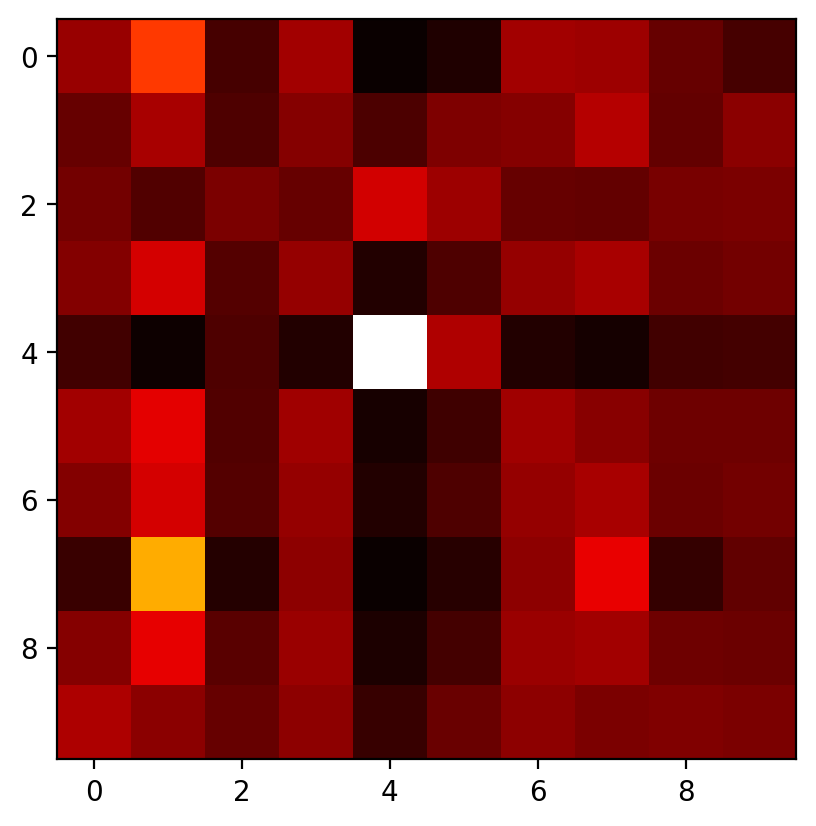

In [67]:
plt.imshow(attns.detach().numpy(), cmap='hot', interpolation='nearest')

In [71]:
df = pd.DataFrame(attns.detach().numpy())
df

,0,1,2,3,4,5,6,7,8,9
0,0.102279,0.116902,0.095548,0.103101,0.090652,0.092365,0.103101,0.102647,0.097894,0.095509
1,0.098137,0.103838,0.096373,0.100781,0.096004,0.100102,0.100781,0.104920,0.097907,0.101158
2,0.099379,0.096506,0.099920,0.098203,0.107403,0.102867,0.098203,0.097955,0.099648,0.099917
3,0.100661,0.107542,0.096716,0.102229,0.092731,0.096318,0.102229,0.103722,0.098675,0.099177
4,0.093831,0.089897,0.094899,0.091359,0.157125,0.103029,0.091359,0.090467,0.093837,0.094197
5,0.103120,0.109096,0.096438,0.103056,0.091776,0.094960,0.103056,0.100971,0.098732,0.098796
6,0.100661,0.107542,0.096716,0.102229,0.092731,0.096318,0.102229,0.103722,0.098675,0.099177
7,0.094160,0.128211,0.092408,0.100973,0.090542,0.092696,0.100973,0.109109,0.093650,0.097276
8,0.100667,0.109200,0.097085,0.102458,0.092360,0.095326,0.102458,0.103196,0.098727,0.098525
9,0.104278,0.101318,0.098286,0.101434,0.094502,0.098512,0.101434,0.099883,0.100485,0.099867


In [73]:
df.sum(axis=1)

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    1.0
8    1.0
9    1.0
dtype: float32

In [77]:
updated_embedding_1.shape

torch.Size([10, 10, 8])

In [78]:
vs[0].shape

torch.Size([1, 8])